In [24]:
import cv2
import os
import numpy as np

In [25]:
path = "/Users/namluu/Downloads/face-recognition"

EMBEDDING_FL = os.path.join(path, "nn4.small2.v1.t7")
DATASET_PATH = os.path.join(path, "Dataset")

def _load_torch(model_path_fl):
  model = cv2.dnn.readNetFromTorch(model_path_fl)
  return model
encoder = _load_torch(EMBEDDING_FL)

In [3]:
import cv2

def _blobImage(image, out_size = (300, 300), scaleFactor = 1.0, mean = (104.0, 177.0, 123.0)):
  """
  input:
    image: ma trận RGB của ảnh input
    out_size: kích thước ảnh blob
  return:
    imageBlob: ảnh blob
  """
  # Chuyển sang blobImage để tránh ảnh bị nhiễu sáng
  imageBlob = cv2.dnn.blobFromImage(image, 
                                    scalefactor=scaleFactor,   # Scale image
                                    size=out_size,  # Output shape
                                    mean=mean,  # Trung bình kênh theo RGB
                                    swapRB=False,  # Trường hợp ảnh là BGR thì set bằng True để chuyển qua RGB
                                    crop=False)
  return imageBlob

In [4]:
from face_recognition import face_locations
import matplotlib.pyplot as plt

IMAGE_TEST = os.path.join(path, "Dataset/khanh/001.jpg")

def _image_read(image_path):
  """
  input:
    image_path: link file ảnh
  return:
    image: numpy array của ảnh
  """
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image


image = _image_read(IMAGE_TEST)

def _extract_bbox(image, single = True):
  """
  Trích xuất ra tọa độ của face từ ảnh input
  input:
    image: ảnh input theo kênh RGB. 
    single: Lấy ra 1 face trên 1 bức ảnh nếu True hoặc nhiều faces nếu False. Mặc định True.
  return:
    bbox: Tọa độ của bbox: <start_Y>, <start_X>, <end_Y>, <end_X>
  """
  bboxs = face_locations(image)
  if len(bboxs)==0:
    return None
  if single:
    bbox = bboxs[0]
    return bbox
  else:
    return bboxs

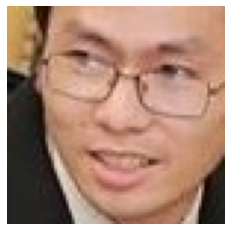

In [5]:
def _extract_face(image, bbox, face_scale_thres = (20, 20)):
  """
  input:
    image: ma trận RGB ảnh đầu vào
    bbox: tọa độ của ảnh input
    face_scale_thres: ngưỡng kích thước (h, w) của face. Nếu nhỏ hơn ngưỡng này thì loại bỏ face
  return:
    face: ma trận RGB ảnh khuôn mặt được trích xuất từ image input.
  """
  h, w = image.shape[:2]
  try:
    (startY, startX, endY, endX) = bbox
  except:
    return None
  minX, maxX = min(startX, endX), max(startX, endX)
  minY, maxY = min(startY, endY), max(startY, endY)
  face = image[minY:maxY, minX:maxX].copy()
  # extract the face ROI and grab the ROI dimensions
  (fH, fW) = face.shape[:2]

  # ensure the face width and height are sufficiently large
  if fW < face_scale_thres[0] or fH < face_scale_thres[1]:
    return None
  else:
    return face

bbox = _extract_bbox(image)
face = _extract_face(image, bbox)
plt.axis("off")
plt.imshow(face)

In [6]:
from imutils import paths
DATASET_PATH = "./Dataset"

def _model_processing(face_scale_thres = (20, 20)):
  """
  face_scale_thres: Ngưỡng (W, H) để chấp nhận một khuôn mặt.
  """
  image_links = list(paths.list_images(DATASET_PATH))
  images_file = [] 
  y_labels = []
  faces = []
  total = 0
  for image_link in image_links:
    split_img_links = image_link.split("/")
    # Lấy nhãn của ảnh
    name = split_img_links[-2] 
    # Đọc ảnh
    image = _image_read(image_link)
    (h, w) = image.shape[:2]
    # Detect vị trí các khuôn mặt trên ảnh. Gỉa định rằng mỗi bức ảnh chỉ có duy nhất 1 khuôn mặt của chủ nhân classes.
    bbox =_extract_bbox(image, single=True)
    # print(bbox_ratio)
    if bbox is not None:
      # Lấy ra face
      face = _extract_face(image, bbox, face_scale_thres = (20, 20))
      if face is not None:
        faces.append(face)
        y_labels.append(name)
        images_file.append(image_links)
        total += 1
      else:
        next
  print("Total bbox face extracted: {}".format(total))
  return faces, y_labels, images_file

faces, y_labels, images_file = _model_processing()

Total bbox face extracted: 142


In [7]:
import pickle

def _save_pickle(obj, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(obj, f)

def _load_pickle(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
  return obj

_save_pickle(faces, "./faces.pkl")
_save_pickle(y_labels, "./y_labels.pkl")
_save_pickle(images_file, "./images_file.pkl")

In [8]:
def _embedding_faces(encoder, faces):
  emb_vecs = []
  for face in faces:
    faceBlob = _blobImage(face, out_size = (96, 96), scaleFactor=1/255.0, mean=(0, 0, 0))
    # Embedding face
    encoder.setInput(faceBlob)
    vec = encoder.forward()
    emb_vecs.append(vec)
  return emb_vecs

embed_faces = _embedding_faces(encoder, faces)
# Nhớ save embed_faces vào Dataset.
_save_pickle(embed_faces, "./embed_blob_faces.pkl")

In [9]:
embed_faces = _load_pickle("./embed_blob_faces.pkl")
y_labels = _load_pickle("./y_labels.pkl")

from sklearn.model_selection import train_test_split
ids = np.arange(len(y_labels))

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(np.stack(embed_faces), y_labels, ids, test_size = 0.2, stratify = y_labels)
X_train = np.squeeze(X_train, axis = 1)
X_test = np.squeeze(X_test, axis = 1)
print(X_train.shape, X_test.shape)
print(len(y_train), len(y_test))

(113, 128) (29, 128)
113 29


In [10]:
_save_pickle(id_train, "./id_train.pkl")
_save_pickle(id_test, "./id_test.pkl")


from sklearn.metrics.pairwise import cosine_similarity

def _most_similarity(embed_vecs, vec, labels):
  sim = cosine_similarity(embed_vecs, vec)
  sim = np.squeeze(sim, axis = 1)
  argmax = np.argsort(sim)[::-1][:1]
  label = [labels[idx] for idx in argmax][0]
  return label

# Lấy ngẫu nhiên một bức ảnh trong test
vec = X_test[1].reshape(1, -1)
# Tìm kiếm ảnh gần nhất
_most_similarity(X_train, vec, y_train)

'baejun'

In [11]:
# def _acc_test(test_set, y_test):
from sklearn.metrics import accuracy_score

y_preds = []
for vec in X_test:
  vec = vec.reshape(1, -1)
  y_pred = _most_similarity(X_train, vec, y_train)
  y_preds.append(y_pred)

print(accuracy_score(y_preds, y_test))

0.6206896551724138


In [13]:
import tensorflow as tf


UsageError: Line magic function `%tensorflow_version` not found.


In [14]:
%tensorflow_version 2.x

UsageError: Line magic function `%tensorflow_version` not found.


In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Lambda, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

def _base_network():
  model = VGG16(include_top = True, weights = None)
  dense = Dense(128)(model.layers[-4].output)
  norm2 = Lambda(lambda x: tf.math.l2_normalize(x, axis = 1))(dense)
  model = Model(inputs = [model.input], outputs = [norm2])
  return model

model = _base_network()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [16]:
faces = _load_pickle("./faces.pkl")

In [17]:
import cv2

faceResizes = []
for face in faces:
  face_rz = cv2.resize(face, (224, 224))
  faceResizes.append(face_rz)

X = np.stack(faceResizes)
X.shape

(142, 224, 224, 3)

In [18]:
id_train = _load_pickle("./id_train.pkl")
id_test = _load_pickle("./id_test.pkl")

X_train, X_test = X[id_train], X[id_test]

print(X_train.shape)
print(X_test.shape)

(113, 224, 224, 3)
(29, 224, 224, 3)


In [20]:
import tensorflow_addons as tfa

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())


In [21]:
print(X_train.shape, len(y_train))

gen_train = tf.data.Dataset.from_tensor_slices((X_train, y_train)).repeat().shuffle(1024).batch(32)
gen_train

(113, 224, 224, 3) 113


<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.uint8, tf.string)>

In [22]:
history = model.fit(
    gen_train,
    steps_per_epoch = 50,
    epochs=10)

Epoch 1/10
10/50 [=====>........................] - ETA: 24:34 - loss: 0.9742

KeyboardInterrupt: 